# Introduction to Data Science

## Statistical Inference

In [4]:
import sys
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage import transform, color, img_as_ubyte

%matplotlib inline

In [5]:
def check_mem():
    # These are the usual ipython objects, including this one you are creating
    ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

    # Get a sorted list of the objects and their sizes
    print(sorted([(x, sys.getsizeof(globals().get(x))) for x in globals() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True))

def get_file_list(df, folder, n_sample = None, seed = None):
    if n_sample is None:
        file_ids_list = df.file_id.values
    else:
        file_ids_list = df.sample(n = n_sample, random_state = seed).file_id.values
    files_list = [folder + '/' + str(file_id) + '.jpg' for file_id in file_ids_list]
    return files_list

def read_image_and_resize(f, w = 100, h = 100):
    img = plt.imread(f)
    img = transform.resize(img, (w, h), mode='constant', anti_aliasing=True)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        img = img_as_ubyte(img)
    img = color.gray2rgb(img)
    img = img[np.newaxis, :, :, :3]
    if img.shape != (1, 100, 100, 3):
        raise ValueError(f + str(img.shape))
    return img

def read_images_4d_array(files_list):
    images_list = [read_image_and_resize(file) for file in files_list]
    images_array = np.concatenate(images_list)
    return images_array

def get_images_matrix(csv_file, folder, n = None, seed = 1976):
    df = pd.read_csv(csv_file)
    files_list = get_file_list(df, folder, n, seed)
    images = read_images_4d_array(files_list)
    return images

def get_all_pixels(x):
    return x.reshape(-1, np.prod(x.shape[1:]))

def get_final_matrices(n_train = None, n_test = None):
    folder = '../../datasets/ebay_boys_girls_shirts/'
    x_boys_train = get_images_matrix(folder + 'boys_train.csv', folder + 'boys', n_train)
    x_boys_test = get_images_matrix(folder + 'boys_test.csv', folder + 'boys', n_test)
    x_girls_train = get_images_matrix(folder + 'girls_train.csv', folder + 'girls', n_train)
    x_girls_test = get_images_matrix(folder + 'girls_test.csv', folder + 'girls', n_test)
    
    x_boys_train_all = get_all_pixels(x_boys_train)
    x_boys_test_all = get_all_pixels(x_boys_test)
    x_girls_train_all = get_all_pixels(x_girls_train)
    x_girls_test_all = get_all_pixels(x_girls_test)

    x_train = np.vstack([x_boys_train_all, x_girls_train_all])
    x_test = np.vstack([x_boys_test_all, x_girls_test_all])

    y_boys_train = np.array([0] * x_boys_train.shape[0])
    y_boys_test = np.array([0] * x_boys_test.shape[0])
    y_girls_train = np.array([1] * x_girls_train.shape[0])
    y_girls_test = np.array([1] * x_girls_test.shape[0])
    y_train = np.concatenate([y_boys_train, y_girls_train])
    y_test = np.concatenate([y_boys_test, y_girls_test])
    
    return x_train, x_test, y_train, y_test

## Basic idea of statistical inference<br><br>

### $  {\Large \mbox{(Distribution/World)}\;\;\;\;\;\;F} \left. \begin{array}{c} \stackrel{\mbox{Sampling}}{\large \longrightarrow} \\
\stackrel{\mbox{Inference}}{\large \longleftarrow}\end{array} \right. {\Large X\;\;\;\;\;\mbox{  (Data) }} $

### The *world* is something we want to learn about: 
1. Do girls' shirts have more red than boys' shirts?
2. Which candidate has more support in the population? 

### We are given a *sample* of data $X$ and want to use it to learn about the population
1. 30 boys' shirts and 20 girls' shirts
2. An election survey 


## Hypothesis testing

### We have a *null* world we believe in unless convinced otherwise: 
1. There is no difference in red level between girls' and boys'
2. The candidates have equal support

### We want to use the sample to determine whether to reject the null:
1. Does the sample contain **clear evidence** of more red in girls? 
2. Does the sample **convincingly indicates** that candidate 1 has higher support? 

### This is often indicated through the p-value, which *calculates* how consistent our data is with the null hypothesis
### Formaly, the p-value measures how *surprising* the data we see is, if the null holds

## Conceptual example: Criminal trial

### In a criminal trial, suspects get convicted only if their guilt proven *beyond reasonable doubt* 
### This is a hypothesis test with null hypothesis: the suspect is innocent
### Data: the evidence the sides bring in trial
### Beyond reasonable doubt: the evidence is not consistent with the null of innocence
### Difference: the decision is based on the judge's intuition, whereas formal hypothesis testing is based on calculating probabilities



## Red shirts example

### We want to examine whether there is more red in girls' shirts vs boys' shirts on Ebay

### The "world" is the 20K images we have: 10K boys, 10K girls

### Imagine we can't check all of them, but can only sample a few of each kind and see the difference

### Our challenge: to determine if it is *convincing* evidence that girls' shirts are redder overall

### Use hypothesis testing approach


In [7]:
folder = '../../datasets/ebay_boys_girls_shirts/'

# the function get_images_matrix was previously defined
boys_sample = get_images_matrix(folder + 'boys_train.csv', folder + 'boys', n = 30, seed = 1976)
girls_sample = get_images_matrix(folder + 'girls_train.csv', folder + 'girls', n = 30, seed = 1976)

boys_red = boys_sample[:, :, :, 0].mean(axis = (1, 2))
girls_red = girls_sample[:, :, :, 0].mean(axis = (1, 2))

print(boys_red[:10])
print(girls_red[:10])

[206.6873 142.7775 200.6834 221.9937 176.6418  50.4814 160.1469 121.421
 216.0849 204.6111]
[ 38.0923 179.1978 216.0276 224.2833 129.7951 113.9222 114.0983 250.197
 241.1484 202.9927]


In [5]:
print(f'Boys shirts mean red value: {boys_red.mean():.2f}')
print(f'Girls shirts mean red value: {girls_red.mean():.2f}')
print(f'Means difference: {girls_red.mean() - boys_red.mean(): .2f}')

Boys shirts mean red value: 165.42
Girls shirts mean red value: 181.39
Means difference:  15.97


It looks as you expected, girls average red pixel is higher by about 16 points, but if you do it again, results would be different, wouldn't they?

In [11]:
boys_sample2 = get_images_matrix(folder + 'boys_train.csv', folder + 'boys', n = 30, seed = 1979)
girls_sample2 = get_images_matrix(folder + 'girls_train.csv', folder + 'girls', n = 30, seed = 1979)

boys_red2 = boys_sample2[:, :, :, 0].mean(axis = (1, 2))
girls_red2 = girls_sample2[:, :, :, 0].mean(axis = (1, 2))

print(f'Boys shirts mean red value: {boys_red2.mean():.2f}')
print(f'Girls shirts mean red value: {girls_red2.mean():.2f}')
print(f'Means difference: {girls_red2.mean() - boys_red2.mean(): .2f}')

Boys shirts mean red value: 163.45
Girls shirts mean red value: 176.27
Means difference:  12.82


Assume sampling is expensive. You have the capacity for 60 shirts of images.

How will you know, that the difference you're seeing is of significance? That it will "stick"? That what everyone is thinking, the null hypothesis, should be rejected, and your alternative hypothesis is more likely?

## The Null Distribution

### Under the null hypothesis, girls and boys shirts come from the same homogenous population.

### To illustrate this we will create an *artificial null* world, made of 20K shirts images in our training dataset. Then we can randomly assign half as girls and half as boys 

### In this world we *know* that girls' shirts and boys' shirts have about the same amount of red


In [6]:
boys_all = get_images_matrix(folder + 'boys_train.csv', folder + 'boys')
girls_all = get_images_matrix(folder + 'girls_train.csv', folder + 'girls')

boys_red_all = boys_all[:, :, :, 0].mean(axis = (1, 2))
girls_red_all = girls_all[:, :, :, 0].mean(axis = (1, 2))
population = np.concatenate([boys_red_all, girls_red_all])

print(population.shape)

(20000,)


## The Null Distribution

### We can sample two random samples of so-called "boys" and so-called "girls" to prove to ourselves that the difference between their means should be about zero:

In [8]:
boys_red_null = np.random.choice(population, 30)
girls_red_null = np.random.choice(population, 30)
print(f'Means difference: {girls_red_null.mean() - boys_red_null.mean(): .2f}')

Means difference: -2.03


### We got a mean difference which is different than zero, *by random*. And again:

In [9]:
boys_red_null = np.random.choice(population, 30)
girls_red_null = np.random.choice(population, 30)
print(f'Means difference: {girls_red_null.mean() - boys_red_null.mean(): .2f}')

boys_red_null = np.random.choice(population, 30)
girls_red_null = np.random.choice(population, 30)
print(f'Means difference: {girls_red_null.mean() - boys_red_null.mean(): .2f}')

Means difference: -4.26
Means difference:  6.19


## The Null Dsitribution

We want to know how is *our* original average difference of about 16 points is in comparison to these **null** average differences between groups coming from the same population. So we'll make a lot of the them and look at their distribution, the Null Distribution of the means difference:

In [10]:
def sample_null_mean_diff(n = 30):
    boys_red_null = np.random.choice(population, n)
    girls_red_null = np.random.choice(population, n)
    return girls_red_null.mean() - boys_red_null.mean()
null_mean_diffs = np.array([sample_null_mean_diff() for i in range(10000)])

print(f'Max null mean diff: {max(null_mean_diffs): .2f}')
print(f'Min null mean diff: {min(null_mean_diffs): .2f}')

Max null mean diff:  42.03
Min null mean diff: -50.54


We can see that the max null mean differences is actually much higher than our original 16 points. So at random, when there is *no difference*, you can get mean differences of over 30 or 40!

Let's look at the Null Distirbution histogram:

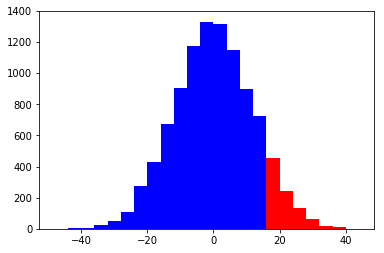

In [14]:
fig, ax = plt.subplots()

N, bins, patches = ax.hist(null_mean_diffs, bins=np.arange(-48, 48, 4))
for i in range(0, 16):
    patches[i].set_facecolor('blue')
for i in range(16, len(patches)):
    patches[i].set_facecolor('red')

plt.show()

It seems like our original value of 16 points difference is not that extreme. There's a measure for that:

## P-Value

How extreme is our original 16 points result?

What is the probability under the Null Distribution, where there is no difference between "boys" and "girls", of getting 16 or higher?

In [17]:
one_sided_p_value = np.mean(null_mean_diffs > 16)
print(f'P(mean_diff >= 16 | H0) = {one_sided_p_value: .2f}')

P(mean_diff >= 16 | H0) =  0.09


It looks like the chance of getting a difference of 16 points or higher, when there is no difference, is ~9%. Does that convince you that there actually is a difference, that indeed the boys and girls samples came from two different, separate, distributions?

It is a standard in both academia and industry to not by persuaded by a p-value larger than a threshold $\alpha$ of 1% or 5% (a.k.a Type I Error, see later).

## P-Value

If the original alternative hypothesis were "Girls shirts images red level is *different* than Boys'", the p-value should have been two sided.

Because the probability of getting our original value or "more extreme" would have meant "more extreme in absolute value":

In [18]:
two_sided_p_value = np.mean(np.abs(null_mean_diffs) > 16)
print(f'P(|mean_diff| >= 16 | H0) = {two_sided_p_value: .2f}')

P(|mean_diff| >= 16 | H0) =  0.17


17-18% chance of observing a result like 16 points or more extreme, at random, when there is no difference. 16 points doesn't look convincing.

But in real life we only have that one hard-earned sample. We don't have the population. And from here, the rest is mathematical approximation for getting that p-value and other measures, with what we have.